In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import time
import os
import numpy as np

In [2]:
training_data=datasets.MNIST(root="dataset",train=True,transform=ToTensor(),download=True)
test_data=datasets.MNIST(root="dataset",train=False,transform=ToTensor(),download=True)
training_data= (training_data.data - 127.5) / 127.5 #normalize -1,1
test_data= (test_data.data - 127.5) / 127.5 #normalize -1,1

In [3]:
from torch.utils.data import DataLoader

In [4]:
train=DataLoader(dataset=training_data,batch_size=32,shuffle=True)
test=DataLoader(dataset=test_data,batch_size=32,shuffle=True)


torch.Size([32, 28, 28])


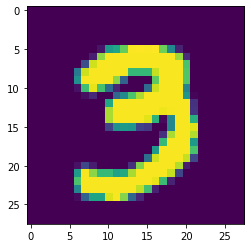

In [5]:
for x in train:
  print(x.shape)
  image=x[0]
  i=x[0].tolist()
  image=image.reshape((28,28))
  plt.imshow(image)
  plt.show()
  break

In [6]:
train

In [7]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
device='cpu'
if torch.cuda.is_available():
  device='cuda'

In [9]:
device

'cuda'

In [10]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1=nn.Linear(100,128)
        self.batch_norm1=nn.BatchNorm1d(128)
        self.act1=nn.LeakyReLU()

        self.layer2=nn.Linear(128,256)
        self.batch_norm2=nn.BatchNorm1d(256)
        self.act2=nn.LeakyReLU()

        self.layer3=nn.Linear(256,512)
        self.batch_norm3=nn.BatchNorm1d(512)
        self.act3=nn.LeakyReLU()

        self.layer4=nn.Linear(512,28*28)
        self.act4=nn.Tanh()
    def forward(self,input):
        res=self.layer1(input)
        res=self.batch_norm1(res)
        res=self.act1(res)
        res=self.layer2(res)
        res=self.batch_norm2(res)
        res=self.act2(res)
        res=self.layer3(res)
        res=self.batch_norm3(res)
        res=self.act3(res)

        res=self.layer4(res)
        res=self.act4(res)

        return res

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()

        self.layer1=nn.Linear(28*28,512)
        self.act1=nn.LeakyReLU()
        
        self.layer2=nn.Linear(512,256)
        self.act2=nn.LeakyReLU()
        self.drop1=nn.Dropout(0.3)

        self.layer3=nn.Linear(256,128)
        self.act3=nn.LeakyReLU()
        self.drop2=nn.Dropout(0.3)

        self.layer4=nn.Linear(128,1)

    def forward(self, input):
        res=self.layer1(input)
        res=self.act1(res)

        res=self.layer2(res)
        res=self.act2(res)
        res=self.drop1(res)

        res=self.layer3(res)
        res=self.act3(res)
        res=self.drop2(res)
        
        res=self.layer4(res)

        return res

In [12]:
from torch.nn.functional import binary_cross_entropy_with_logits
def discriminator_loss(real_output,fake_output):
    real_loss=torch.mean(nn.functional.binary_cross_entropy_with_logits(real_output,torch.ones_like(real_output)))
    fake_loss=torch.mean(nn.functional.binary_cross_entropy_with_logits(fake_output,torch.zeros_like(fake_output)))
    return real_loss+fake_loss

In [13]:
def generator_loss(fake_output):
    gen_loss=nn.functional.binary_cross_entropy_with_logits(fake_output,torch.ones_like(fake_output))
    return torch.mean(gen_loss)

In [14]:
class VanillaGAN:
    def __init__(self):
        self.generator=Generator().to(device)
        self.discriminator=Discriminator().to(device)

        self.write_dir="./images"
        #self.checkpoints_dir="./checkpoints"

        self.gen_opt=torch.optim.Adam(params=self.generator.parameters(),lr=1e-4)
        self.dis_opt=torch.optim.Adam(params=self.discriminator.parameters(),lr=1e-4)

    def train_dis(self,images):
        noise=torch.rand((32,100)).to(device)
        images=images.to(device)
        generated_images=self.generator(noise)

        real_output=self.discriminator(images)
        fake_output=self.discriminator(generated_images)

        loss=discriminator_loss(real_output,fake_output)
        self.dis_opt.zero_grad()
        loss.backward()
        self.dis_opt.step()

            
        return loss

    def train_gan(self):
        noise=torch.rand((32,100)).to(device)
        
        generated_images=self.generator(noise)

        fake_output=self.discriminator(generated_images)

        loss=generator_loss(fake_output)
        self.gen_opt.zero_grad()
        loss.backward()
        self.gen_opt.step()   

        return loss

    def train(self):
        if not os.path.exists(self.write_dir):
            os.mkdir(self.write_dir)

        for epoch in range(50):
            start=time.time()

            for batch ,(x) in enumerate(train):
                x = x.reshape((32,28*28))
                d_loss=self.train_dis(x)
                
                if batch%2==0:
                    g_loss=self.train_gan()

            print(f'E: {epoch + 1}, G: {g_loss}, D: {d_loss}, T: {time.time() - start}')
        self.save()

    def save(self):
        r, c = 2, 5
        noise = torch.rand([r * c, 100]).to(device)

        generated_images = self.generator(noise)
        generated_images = 0.5 * generated_images + 0.5
        cnt=0
        for x in generated_images:
            fig=torch.reshape(x,(28,28)).cpu().tolist()
            with open(os.path.join(self.write_dir, str(cnt)+".json"),'w') as handle:
                json.dump(fig,handle)
            cnt+=1


        print('Saved...')


In [15]:
gan=VanillaGAN()


In [16]:
import json
gan.train()

E: 1, G: 4.058004379272461, D: 0.1266082376241684, T: 20.13530421257019
E: 2, G: 6.941154479980469, D: 0.028791336342692375, T: 12.70083498954773
E: 3, G: 6.814463138580322, D: 0.15854276716709137, T: 12.71111011505127
E: 4, G: 4.911128997802734, D: 0.0264425165951252, T: 13.302829504013062
E: 5, G: 3.8377532958984375, D: 0.12623459100723267, T: 12.74494457244873
E: 6, G: 3.4952054023742676, D: 0.262398898601532, T: 12.687777042388916
E: 7, G: 2.613692283630371, D: 0.18906813859939575, T: 12.931857585906982
E: 8, G: 3.5479302406311035, D: 0.29697126150131226, T: 13.566110134124756
E: 9, G: 3.116835117340088, D: 0.334770143032074, T: 12.820598363876343
E: 10, G: 2.729870080947876, D: 0.3559652268886566, T: 12.678114891052246
E: 11, G: 4.944236755371094, D: 0.2901512086391449, T: 12.691380023956299
E: 12, G: 2.2080254554748535, D: 0.4118938446044922, T: 12.734567880630493
E: 13, G: 2.104031562805176, D: 0.4279175400733948, T: 18.7630877494812
E: 14, G: 2.422074794769287, D: 0.41234266757

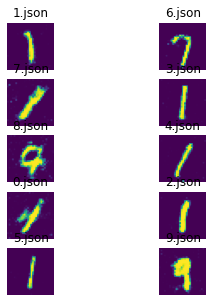

In [17]:
r=2
c=5
figure=plt.figure(figsize=(5,5))
cnt=1
for x in os.listdir("images"):
    if x.endswith("json"):
       image=0
       with open("images/"+x,'r') as handle:
            image=json.load(handle)
       #image=np.asarray(image)
       figure.add_subplot(c,r,cnt)
       #print(x)
       plt.title(x)
       plt.axis("off")
       plt.imshow(image)
       cnt+=1
plt.show()